# evaluomeR PCA

In [60]:
library("evaluomeR")
library("psych")
library("REdaS")
library("scales")
library("caret")

options(scipen=10)

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: ggplot2

Attaching package: 'ggplot2'

The following objects are masked from 'package:psych':

    %+%, alpha

The following object is masked from 'package:randomForest':

    margin



In [ ]:
# https://www.r-data-scientist.com/es/blog/statistical-tests/bartlett-test/
# https://www.r-data-scientist.com/es/blog/statistical-tests/kaiser-meyer-olkin-test/

# Table of contents
* [PCA](#pca)
* [Bartlett Sphericity Test](#bartlett)
    * [Bartlett Sphericity Test - Conclusiones](#bartlett-conclusion)
* [Kaiser-Meyer-Olkin Test](#kmo)
* [References](#references)

# PCA <a class="anchor" id="pca"></a>

In [37]:
# data("rnaMetrics")
seed = 13606
scaled = TRUE
k.range=c(2,6)
set.seed(seed)
input_df = read.csv(paste0(getwd(), "/","../../usecases/usecase2/data/agro.csv"), header=TRUE, stringsAsFactors=FALSE)
#input_df = read.csv(paste0(getwd(), "/","../../usecases/usecase2/data/obo-119.csv"), header=TRUE, stringsAsFactors=FALSE)
#input_df = as.data.frame(assay(rnaMetrics))
data = input_df[-1]

In [41]:
if (scaled) {
    data = scales::rescale(as.matrix(data), to=c(0,1))
}
head(data)

In [43]:
data.pca = princomp(data, cor = TRUE)
# Calcular la proporción acumulada de la varianza explicada de los factores
parte.pca <- data.pca$sdev^2/sum(data.pca$sdev^2)*100

In [44]:
print(parte.pca)

      Comp.1       Comp.2       Comp.3       Comp.4       Comp.5       Comp.6 
3.770477e+01 1.617399e+01 1.023493e+01 8.436831e+00 7.270416e+00 5.503505e+00 
      Comp.7       Comp.8       Comp.9      Comp.10      Comp.11      Comp.12 
3.810833e+00 3.350284e+00 2.136361e+00 1.980596e+00 1.814285e+00 8.926306e-01 
     Comp.13      Comp.14      Comp.15      Comp.16      Comp.17      Comp.18 
3.532935e-01 2.829189e-01 4.808988e-02 6.268514e-03 4.145966e-16 0.000000e+00 
     Comp.19 
0.000000e+00 


In [45]:
print(cumsum(parte.pca))

   Comp.1    Comp.2    Comp.3    Comp.4    Comp.5    Comp.6    Comp.7    Comp.8 
 37.70477  53.87876  64.11369  72.55052  79.82093  85.32444  89.13527  92.48556 
   Comp.9   Comp.10   Comp.11   Comp.12   Comp.13   Comp.14   Comp.15   Comp.16 
 94.62192  96.60251  98.41680  99.30943  99.66272  99.94564  99.99373 100.00000 
  Comp.17   Comp.18   Comp.19 
100.00000 100.00000 100.00000 


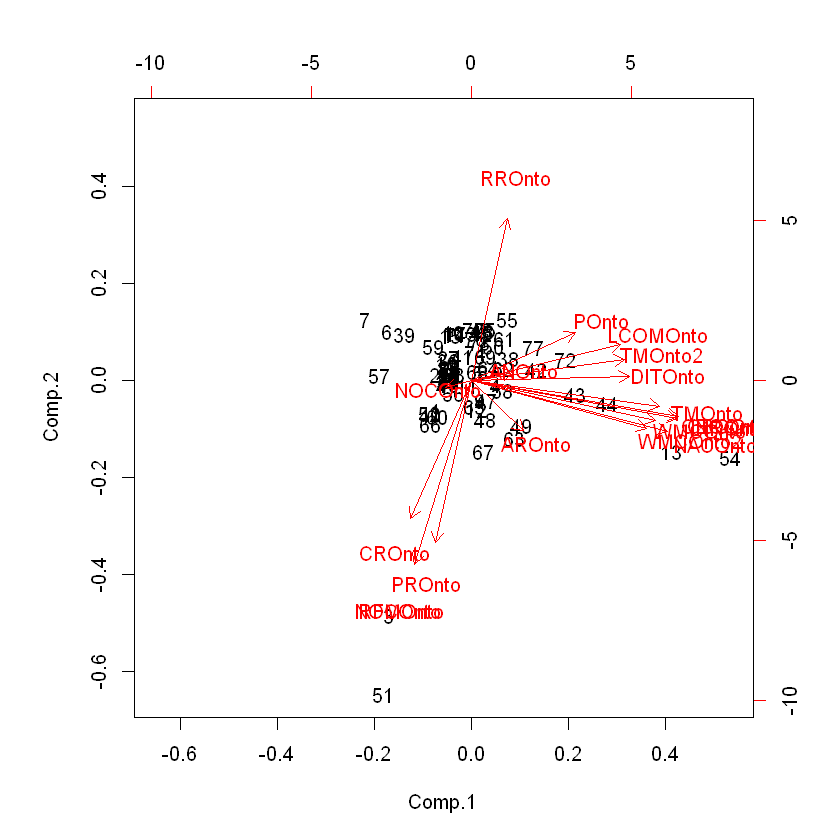

In [46]:
# Representación gráfica del PCA
biplot(data.pca)

# Bartlett Sphericity Test <a class="anchor" id="bartlett"></a>

In [120]:
R = cor(data)
#print(correlations)

In [84]:
cor_metrics = findCorrelation(R, cutoff = 0.99, verbose = FALSE, names=TRUE)

In [91]:
as.character(cor_metrics)

[1] "CBOOnto"  "CBOOnto2" "RFCOnto"  "PROnto"

In [121]:
R = R[, !colnames(R) %in% cor_metrics]
R = R[!rownames(R) %in% cor_metrics, ]
ncol(R)
nrow(R)

In [124]:
print(cortest.bartlett(R, n = nrow(data)))

$chisq
[1] 1115.857

$p.value
[1] 1.373885e-168

$df
[1] 105



## Bartlett Sphericity Test  - Conclusion<a class="anchor" id="bartlett-conclusion"></a>

Se rechaza la hipótesis nula al nivel del 5% (valor p=0<0.05). Por lo tanto, se puede realizar de manera eficiente un PCA en el conjunto de datos.

**Nota**:
La prueba de Bartlett tiene un gran inconveniente. Tiende a ser siempre estadísticamente significativo cuando aumenta el número de instancias n.

Algunas referencias aconsejan utilizar esta prueba solo si la relación n:p (número de instancias dividido entre el número de variables) es inferior a 5.

In [125]:
# Relación n:p es 4.10:
nrow(data)/ncol(data)

[1] 4.105263

# Kaiser-Meyer-Olkin Test <a class="anchor" id="kmo"></a>


In [127]:
R = cor(data)

In [128]:
R = R[, !colnames(R) %in% cor_metrics]
R = R[!rownames(R) %in% cor_metrics, ]
ncol(R)
nrow(R)

[1] 15

[1] 15

In [129]:
kmo_value = psych::KMO(R)

In [130]:
kmo_value$MSA

[1] 0.6370788

La matriz de correlación parcial se puede obtener a partir de la matriz de correlación. Se calcula la inversa de esta última:

![equation](https://latex.codecogs.com/svg.image?R^{-1}=(v)_{ij})

In [ ]:
invR <- solve(R)
print(invR)

In [ ]:
# Matriz de correlación parcial
A <- matrix(1, nrow(invR), ncol(invR))
for (i in 1:nrow(invR)){
  for (j in (i):ncol(invR)){
    # Sobre la diagonal
    A[i,j] <- -invR[i,j]/sqrt(invR[i,i]*invR[j,j])
    # Debajo de la diagonal
    A[j,i] <- A[i,j]
  }
}

colnames(A) <- colnames(data)
rownames(A) <- colnames(data)
print(A)

In [ ]:
kmo.num <- sum(R^2) - sum(diag(R^2))
kmo.denom <- kmo.num + (sum(A^2) - sum(diag(A^2)))
kmo <- kmo.num/kmo.denom
print("KMO index:")
print(kmo)

Si el índice KMO es alto (≈1), el PCA puede actuar de manera eficiente.
Si el índice KMO es bajo (≈0), el PCA no es relevante.

In [ ]:
bart_spher(data)

In [ ]:
KMOS(data)

# References <a class="anchor" id="references"></a>

<a id="1">[1]</a>
https://www.r-data-scientist.com/es/blog/statistical-tests/bartlett-test/
